# Proxy 패턴


## P.1 소개

* Proxy 패턴 (Structural Design Pattern)
* proxy패턴은 '접근제어'를 위해 사용한다 (controlling object access)
    * "a class functioning as an interface to something else"
    * 사용하려는 객체를 대신해서 서비스를 처리함 - 지점이 은행본점의 업무를 대신해서 처리하는 경우
    * 서버에 있는 원격객체를 호출, 즉 다른 jvm에 있는 객체를 호출할 경우
        * 서버 원격객체의 stub을 클라이언트에 생성해서 이 stub을 사용함.
        * 클라이언트 측의 stub이 서버의 proxy.
        * stub의 proxy역할
            * 클라이언트의 서버 원격객체에 대한 요청을 로컬에서 처리함. 클라이언트은 처리를 요청할 권한이 있어야 한다.
* proxy의 종류
    * remote proxy
        * 분산네트워크환경에서 원격객체를 대신해서 로컬jvm에 생성하는 proxy.
        * proxy가 요청을 받아서, 원격의 다른 jvm에 있는 객체를 연결.
    * virtual proxy
        * 객체를 필요할 경우 생성하고, virtual proxy를 사용함.
        * image proxy (로딩할 때까지, 적은 icon을 사용함)
    * protection proxy
        * invocation handler

* 디자인패턴 요소
요소 | 설명
---|---
name | Proxy
problem | 사용하려는 객체가 멀리 있거나, 바쁘거나, 크거나 직접 사용하기 어려움.
solution | 대리 객체를 만듦.
consequence | 요청과 처리의 decopupling, 실제 사용하려는 객체의 부하를 줄임. 구현이 복잡해짐.

* cases
    * 분산시스템에서 많이 사용된다.
        * CORBA ORB (Object Request Broker)
        * MS Object Linking and Embedding
        * Web proxy - forward HTTP requests (e.g., Apache (with mod_proxy or Traffic Server)
    * image proxy
    * exercise (by Sat to git: 50% for 1 day late deadline) 
        * case extension
            * gumball mahcine 분산객체를 구현 ('고장' state 포함).
        * new case - calculator
            * 간단한 연산을 RMI로 구현 (더하기, 빼기, 곱하기, 나누기).

## P.2 문제

* 접근의 제어
    * 사용하려는 객체가, 멀리 떨어져 있거나
    * 메모리에 상주하지만 매우 크거나
    * 성능을 향상하려거나, 보안을 강화할 경우

* 클라이언트가 사용하려는 객체를 바로 사용함.

In [ ]:
import iplantuml

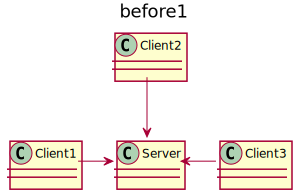

In [8]:
%%plantuml
@startuml
title before1
class Server
Client1 -right-> Server
Client2 -down-> Server
Client3 -left-> Server
@enduml

## P.3 설계

* 역할을 분리함 - 접근을 제어하는 부분을 분리함 access control
    * client - 처리 요청
    * proxy - 클라이언트 측에 생성 (서버의 stub, skeleton)
    * server - 클라이언트 요청 처리
    * object registry
        * 서버가 오브젝트를 이름으로 등록함.
        * 클라이언트가 여기를 찾아서 원하는 함수를 호출함.

* 처리 순서
    * 클라이언트가 처리를 요청한다.
    * 클라이언트측의 proxy가 그 요청을 받는다.
    * proxy가 요청에 필요한 준비를 하고 (사전처리), 서버에 처리를 요청한다.
    * 서버가 처리를 한다.
    * proxy가 서버의 처리결과를 받아서 필요한 사후처리를 하고, 클라이언트에게 그 결과를 돌려준다.

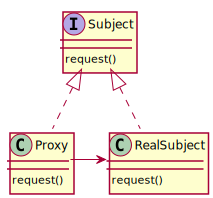

In [10]:
%%plantuml
@startuml
interface Subject {
    request()
}
class RealSubject {
    request()
}
class Proxy {
    request()
}
Subject <|.. RealSubject
Subject <|.. Proxy
Proxy -right-> RealSubject
@enduml

## P.4 Case Implementation

### P.4.1 gumball machine

* 교재 HFDP Ch11 'gumball'
    * client - GumballMonitor
    * server - GumballMachine <|.. GumballMachineRemote
* GumballMonitorTestDrive클래스의 hostname을 변경하고 실행함.

### 단계
    1. 구현
        * remote server interface
            ```
            public interface GumballMachineRemote extends Remote 
            ```
        * remote server implementation
            * GumballMachine
                * 상속 UnicastRemoteObject, 구현 Remote
                * 생성자에 RemoteExeption
                ```
                public class GumballMachine extends UnicastRemoteObject implements GumballMachineRemote
                ```
            * GumballMachineTestDrive
                * binding
                ```
                Naming.rebind("//" + args[0] + "/gumballmachine", gumballMachine);
                ```
        * client
            * GumballMonitor
            * GumballMonitorTestDrive
                * lookup
                    ```
                    (GumballMachineRemote) Naming.lookup(location[i]);
                    ```
            * serializable objects
                * state
                    ```
                    public interface State extends Serializable
                    ```
                * child substates
                    ```
                    transient GumballMachine gumballMachine;
                    ```

    2. compile
        ```
        javac -d classes/ -sourcepath src/ src/headfirst/proxy/gumball/*.java
        (optional) rmic -d classes/ -classpath classes/ headfirst.proxy.gumball.GumballMachine
        ```
    3. run
    
        3-1. run server
            * default port 1099
            ```
            cd classes/
            rmiregistry &
            java -cp classes/ headfirst.proxy.gumball.GumballMachineTestDrive localhost 100
            ```
        3-2. run client
            ```
            java -cp classes/ headfirst.proxy.gumball.GumballMonitorTestDrive localhost
            ```

* State 인터페이스는 네트워크에서 사용되므로 Serializable
    * 객체를 bytes로 바꾸어 파일로 저장해서 전달 (주소ref가 아니라) (marshaling)
    * transient - Seriablizable할 때, 제외할 변수 (즉, 저장하지 않음)

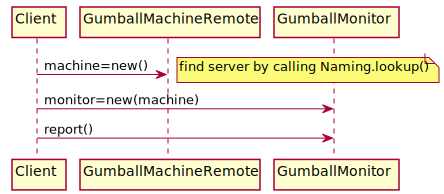

In [5]:
%%plantuml
@startuml
Client -> GumballMachineRemote:machine=new()
    note right: find server by calling Naming.lookup()
Client -> GumballMonitor:monitor=new(machine)
Client -> GumballMonitor:report()
@enduml

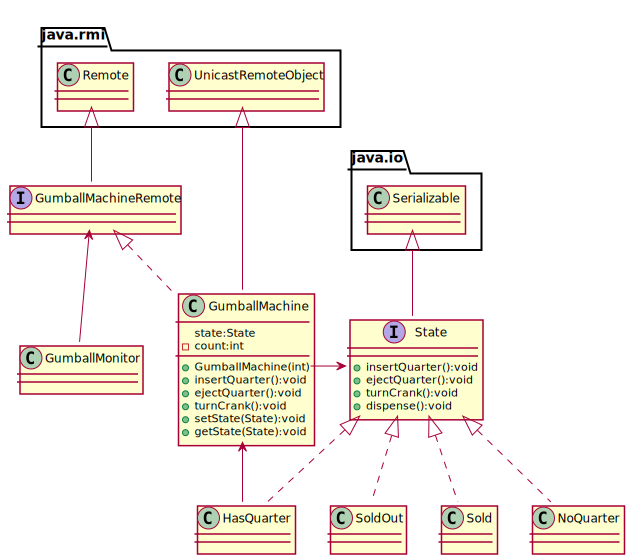

In [4]:
%%plantuml
@startuml
interface GumballMachineRemote
class GumballMachine {
    state:State
    -count:int
    +GumballMachine(int)
    +insertQuarter():void
    +ejectQuarter():void
    +turnCrank():void
    +setState(State):void
    +getState(State):void
}

GumballMachineRemote -up-|> java.rmi.Remote
GumballMachine -up-|> java.rmi.UnicastRemoteObject
GumballMachine .up.|> GumballMachineRemote

interface State {
    +insertQuarter():void
    +ejectQuarter():void
    +turnCrank():void
    +dispense():void
}
java.io.Serializable <|-- State
State <|.. HasQuarter
State <|.. NoQuarter
State <|.. SoldOut
State <|.. Sold
GumballMachine -right-> State
GumballMonitor -up-> GumballMachineRemote
HasQuarter --> GumballMachine
@enduml

In [ ]:
# %load src/headfirst/proxy/gumball/GumballMachineRemote.java
package headfirst.proxy.gumball;

import java.rmi.*;
 
public interface GumballMachineRemote extends Remote {
	public int getCount() throws RemoteException;
	public String getLocation() throws RemoteException;
	public State getState() throws RemoteException;
}


In [ ]:
# %load src/headfirst/proxy/gumball/GumballMachine.java
package headfirst.proxy.gumball;

import java.rmi.*;
import java.rmi.server.*;
 
public class GumballMachine
		extends UnicastRemoteObject implements GumballMachineRemote 
{
	State soldOutState;
	State noQuarterState;
	State hasQuarterState;
	State soldState;
	State winnerState;
 
	State state = soldOutState;
	int count = 0;
 	String location;

	public GumballMachine(String location, int numberGumballs) throws RemoteException {
		soldOutState = new SoldOutState(this);
		noQuarterState = new NoQuarterState(this);
		hasQuarterState = new HasQuarterState(this);
		soldState = new SoldState(this);
		winnerState = new WinnerState(this);

		this.count = numberGumballs;
 		if (numberGumballs > 0) {
			state = noQuarterState;
		} 
		this.location = location;
	}
 
 
	public void insertQuarter() {
		state.insertQuarter();
	}
 
	public void ejectQuarter() {
		state.ejectQuarter();
	}
 
	public void turnCrank() {
		state.turnCrank();
		state.dispense();
	}

	void setState(State state) {
		this.state = state;
	}
 
	void releaseBall() {
		System.out.println("A gumball comes rolling out the slot...");
		if (count != 0) {
			count = count - 1;
		}
	}

	public void refill(int count) {
		this.count = count;
		state = noQuarterState;
	}
 
	public int getCount() {
		return count;
	}
 
    public State getState() {
        return state;
    }
 
    public String getLocation() {
        return location;
    }
  
    public State getSoldOutState() {
        return soldOutState;
    }

    public State getNoQuarterState() {
        return noQuarterState;
    }

    public State getHasQuarterState() {
        return hasQuarterState;
    }

    public State getSoldState() {
        return soldState;
    }

    public State getWinnerState() {
        return winnerState;
    }
 
	public String toString() {
		StringBuffer result = new StringBuffer();
		result.append("\nMighty Gumball, Inc.");
		result.append("\nJava-enabled Standing Gumball Model #2004");
		result.append("\nInventory: " + count + " gumball");
		if (count != 1) {
			result.append("s");
		}
		result.append("\n");
		result.append("Machine is " + state + "\n");
		return result.toString();
	}
}


In [ ]:
# %load src/headfirst/proxy/gumball/GumballMachineTestDrive.java
package headfirst.proxy.gumball;
import java.rmi.*;

public class GumballMachineTestDrive {
 
	public static void main(String[] args) {
		GumballMachineRemote gumballMachine = null;
		int count;

		if (args.length < 2) {
			System.out.println("GumballMachine <name> <inventory>");
 			System.exit(1);
		}

		try {
			count = Integer.parseInt(args[1]);

			gumballMachine = 
				new GumballMachine(args[0], count);
			Naming.rebind("//" + args[0] + "/gumballmachine", gumballMachine);
		} catch (Exception e) {
			e.printStackTrace();
		}
	}
}


In [ ]:
# %load src/headfirst/proxy/gumball/GumballMonitor.java
package headfirst.proxy.gumball;

import java.rmi.*;
 
public class GumballMonitor {
	GumballMachineRemote machine;
 
	public GumballMonitor(GumballMachineRemote machine) {
		this.machine = machine;
	}
 
	public void report() {
		try {
			System.out.println("Gumball Machine: " + machine.getLocation());
			System.out.println("Current inventory: " + machine.getCount() + " gumballs");
			System.out.println("Current state: " + machine.getState());
		} catch (RemoteException e) {
			e.printStackTrace();
		}
	}
}


In [ ]:
# %load src/headfirst/proxy/gumball/GumballMonitorTestDrive.java
package headfirst.proxy.gumball;

import java.rmi.*;
 
public class GumballMonitorTestDrive {
    public static void main(String[] args) {
        String[] location = {"rmi://localhost/gumballmachine",
                             "rmi://localhost/gumballmachine",
                             "rmi://localhost/gumballmachine"}; 
        //String[] location = {"rmi://santafe.localhost/gumballmachine",
        //                     "rmi://boulder.localhost/gumballmachine",
        //                     "rmi://seattle.localhost/gumballmachine"}; 
        if (args.length >= 0) {
            location = new String[1];
            location[0] = "rmi://" + args[0] + "/gumballmachine";
        }
        GumballMonitor[] monitor = new GumballMonitor[location.length];
        for (int i=0;i < location.length; i++) {
            try {
                GumballMachineRemote machine = 
                    (GumballMachineRemote) Naming.lookup(location[i]);
                monitor[i] = new GumballMonitor(machine);
                System.out.println(monitor[i]);
            } catch (Exception e) {
                e.printStackTrace();
            }
        }
 
        for(int i=0; i < monitor.length; i++) {
            monitor[i].report();
        }
    }
}


In [ ]:
# %load src/headfirst/proxy/gumball/State.java
package headfirst.proxy.gumball;

import java.io.*;
  
public interface State extends Serializable {
	public void insertQuarter();
	public void ejectQuarter();
	public void turnCrank();
	public void dispense();
}


In [ ]:
# %load src/headfirst/proxy/gumball/HasQuarterState.java
package headfirst.proxy.gumball;

import java.util.Random;

public class HasQuarterState implements State {
	Random randomWinner = new Random(System.currentTimeMillis());
	transient GumballMachine gumballMachine;
 
	public HasQuarterState(GumballMachine gumballMachine) {
		this.gumballMachine = gumballMachine;
	}
  
	public void insertQuarter() {
		System.out.println("You can't insert another quarter");
	}
 
	public void ejectQuarter() {
		System.out.println("Quarter returned");
		gumballMachine.setState(gumballMachine.getNoQuarterState());
	}
 
	public void turnCrank() {
		System.out.println("You turned...");
		int winner = randomWinner.nextInt(10);
		if (winner == 0) {
			gumballMachine.setState(gumballMachine.getWinnerState());
		} else {
			gumballMachine.setState(gumballMachine.getSoldState());
		}
	}

    public void dispense() {
        System.out.println("No gumball dispensed");
    }
 
	public String toString() {
		return "waiting for turn of crank";
	}
}


* compile
    * rmic를 실행하여 stubs, skeletons을 생성하지 않아도 된다.

In [11]:
!javac -d classes/ -sourcepath src/ src/headfirst/proxy/gumball/*.java

* run rmiregistry
    * 주의: rmiregistry는 classes 디렉토리에서 실행한다.
    * notebook에서는 process실행은 지원하지 않는다.
    ```
    cd ./classes/
    rmiregistry &
    ```
    * rmiregistry가 실행되고 있는지 확인한다. 다시 실행할 경우에는 프로세스를 삭제해야 한다.
    ```
    ps -ax | grep rmiregistry
    pkill rmiregistry
    ```

In [1]:
!ps -ax | grep rmiregistry

32151 ttys005    0:00.21 /usr/bin/rmiregistry
32158 ttys006    0:00.01 /bin/sh -c ps -ax | grep rmiregistry
32160 ttys006    0:00.00 grep rmiregistry


* 서버 실행
    * 프로젝트 디렉토리로 이동해서, 서버를 실행한다.
    * 서버실행은 notebook에서 지원하지 않는다.
    * 명령창으로 나가서 서버를 실행한다 (아래 명령어).
    * 실행하고 나면, 명령창이 대기 상태로 전환된다.
    ```
    java -cp classes/ headfirst.proxy.gumball.GumballMachineTestDrive localhost 100
    ```

* 클라이언트 실행
    * 명령창에서 서버가 실행상태, 즉 클라이언트의 호출을 대기하고 있다.

In [2]:
!java -cp classes/ headfirst.proxy.gumball.GumballMonitorTestDrive localhost

headfirst.proxy.gumball.GumballMonitor@6569a85d
Gumball Machine: localhost
Current inventory: 100 gumballs
Current state: waiting for quarter
